In [1]:
from convolutional_coding import Convolution
from jpeg import compress,decompress
from awgn import add_awgn_noise
from crc32 import crc32,verify_crc32
from hexString_to_bitList import get_bitList_from_hexString,get_hexString_from_bitList
import matplotlib.pyplot as plt
import cv2
import base64
import math

In [2]:
# 原始图像路径,灰度图像
img_path = './sender_image/image.png'
# 读取原始图像,cv2.imread()默认是用color模式读取的，保持原样读取要加上第二个参数-1,即CV_LOAD_IMAGE_GRAYSCALE
# 得到图像原数据流
img_data = cv2.imread(img_path)[:,:,[2,1,0]]
cv2.imwrite('./sender_image/jpeg_decompress.jpg', img_data)
img0 = cv2.imread('./sender_image/jpeg_decompress.jpg')

In [3]:
# 得到压缩后图像数据
img_compress = compress(img_data, 50)
# 得到解压缩后图像数据的二进制列表形式
img_compress=get_bitList_from_hexString(img_compress)

In [4]:
# 将待发送的文件分割成多个数据包，每个数据包的大小为packet_size字节，分别对每一个数据包先进行crc32编码，再进行卷积编码，然后添加到发送队列中
packet_size = 1024
# 实例化一个(2,1,k)卷积编码器，2<=k<=8
conv = Convolution(2)

In [5]:
send_data=[]#待发送的数据包队列
send_data_length=math.ceil(len(img_compress)/8/packet_size)#待发送数据包队列长度
for i in range(send_data_length-1):
    send_bag=img_compress[i*packet_size*8:(i+1)*packet_size*8]#取出一个待发送队列的数据包
    send_bag_crc32=crc32(send_bag)#对待发送的数据包进行crc32编码
    send_bag_crc32_conv=conv.encode_conv(send_bag_crc32)#对crc32编码后的数据包进行卷积编码
    send_data.append(send_bag_crc32_conv)#将编码后的数据包添加到发送队列中
send_bag=img_compress[(send_data_length-1)*packet_size*8:]#取出最后一个待发送的数据包
send_bag_crc32=crc32(send_bag)#对待发送的数据包进行crc32编码
send_bag_crc32_conv=conv.encode_conv(send_bag_crc32)#对crc32编码后的数据包进行卷积编码
send_data.append(send_bag_crc32_conv)#将编码后的数据包添加到发送队列中

In [6]:
#模拟发送端发送数据包、信道传输、接收端viterbi译码、crc校验、数据包错误重传
recv_data=[]#接收到的数据
failure_count=0#数据包错误重传次数
for i in range(send_data_length):
    num=0
    send_bag=send_data[i]#取出一个待发送的数据包
    while True:
        #对数据包加入高斯白噪声，模拟awgn信道传输
        recv_bag=add_awgn_noise(send_bag,20)
        #对接收到的数据包进行viterbi译码
        recv_bag=conv.decode_conv(recv_bag)
        #对接收到的数据包进行crc32校验
        if verify_crc32(recv_bag):
            recv_data.append(recv_bag[:-32])#校验通过,数据包接收成功
            break
        failure_count+=1
        num+=1
    print('第',i,'个包传输失败次数:',num)
print('数据包传输失败次数:',failure_count)

第 0 个包传输失败次数: 0
第 1 个包传输失败次数: 0
第 2 个包传输失败次数: 0
第 3 个包传输失败次数: 0
第 4 个包传输失败次数: 0
第 5 个包传输失败次数: 0
第 6 个包传输失败次数: 0
第 7 个包传输失败次数: 0
第 8 个包传输失败次数: 0
第 9 个包传输失败次数: 0
第 10 个包传输失败次数: 0
第 11 个包传输失败次数: 0
第 12 个包传输失败次数: 0
第 13 个包传输失败次数: 0
第 14 个包传输失败次数: 0
第 15 个包传输失败次数: 0
第 16 个包传输失败次数: 0
第 17 个包传输失败次数: 0
第 18 个包传输失败次数: 0
第 19 个包传输失败次数: 0
第 20 个包传输失败次数: 0
第 21 个包传输失败次数: 0
第 22 个包传输失败次数: 0
第 23 个包传输失败次数: 0
第 24 个包传输失败次数: 0
第 25 个包传输失败次数: 0
第 26 个包传输失败次数: 0
第 27 个包传输失败次数: 0
第 28 个包传输失败次数: 0
第 29 个包传输失败次数: 0
第 30 个包传输失败次数: 0
第 31 个包传输失败次数: 0
第 32 个包传输失败次数: 0
第 33 个包传输失败次数: 0
第 34 个包传输失败次数: 0
第 35 个包传输失败次数: 0
第 36 个包传输失败次数: 0
数据包传输失败次数: 0


In [7]:
# 将接收到的数据包合并成一个数据流
temp = []
for i in range(len(recv_data)):
    temp.extend(recv_data[i])
recv_data = temp
# 将接收到的数据流转换成16进制字符串
recv_data = get_hexString_from_bitList(recv_data)
# 存储压缩后的图像
img_compress_path = './receive_image/img_compress.jpg'
with open(img_compress_path, 'wb') as f:
    f.write(base64.b16decode(recv_data.upper()))

In [8]:
# jpeg解压缩
img_decompress = decompress(img_compress_path)

error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4030: error: (-215:Assertion failed) func != 0 in function 'resize'


In [ ]:
# 读取发送端压缩后的图像
img1 = cv2.imread('./receive_image/img_compress.jpg')[:,:,[2,1,0]]


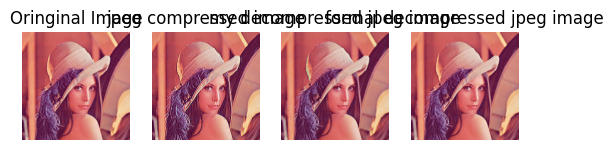

In [ ]:

# 结果展示
# 子图1，原始图像
plt.subplot(141)
# imshow()对图像进行处理，画出图像，show()进行图像显示
plt.imshow(img_data, cmap=plt.cm.gray)
plt.title('Oringinal Image')
# 不显示坐标轴
plt.axis('off')
 # 子图2，jpeg压缩后图像
plt.subplot(142)
plt.imshow(img1, cmap=plt.cm.gray)
plt.title('jpeg compressed image')
plt.axis('off')

 # 子图3，自己写的jpeg压缩后解压的图像
plt.subplot(143)
plt.imshow(img_decompress, cmap=plt.cm.gray)
plt.title('my decompressed jpeg image')
plt.axis('off')

 # 子图4，官方jpeg压缩后解码图像
plt.subplot(144)
plt.imshow(img0, cmap=plt.cm.gray)
plt.title('formal decompressed jpeg image')
plt.axis('off')

plt.show()

